In [0]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.distributions import Categorical

In [0]:
gamma = 0.9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# REINFORCE

In [0]:
class policy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size):
        super(policy, self).__init__()
        self.action_dim = action_dim
        self.l1 = nn.Linear(state_dim, hidden_size)
        self.l2 = nn.Linear(hidden_size, action_dim)

    def forward(self, state):
        x = F.relu(self.l1(state))
        x = F.softmax(self.l2(x), dim=1)
        return x 
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(Variable(state))
        action = np.random.choice(self.action_dim, p=np.squeeze(probs.detach().numpy()))
        ln_prob = torch.log(probs.squeeze(0)[action])
        return action, ln_prob


In [0]:
def train(pol, rewards, log_probs, lr):
    discounted_rewards = []
    optimizer = torch.optim.Adam(pol.parameters(), lr=lr)
    for t in range(len(rewards)):
        Gt = 0 
        k = 0
        for r in rewards[t:]:
            Gt = Gt + gamma**k * r
            k = k + 1
        discounted_rewards.append(Gt)
        
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards

    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)
    
    optimizer.zero_grad()
    policy_gradient = torch.stack(policy_gradient).sum()
    policy_gradient.backward()
    optimizer.step()

In [0]:
def reinforce(seed=0, silent=True, hidden_size=128, max_episode_nums = 2000, lr=3e-3):
    env = gym.make('CartPole-v0')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    pol = policy(state_dim, action_dim, hidden_size)
    env.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)

    max_episode_num = max_episode_nums
    max_steps = 10000
    numsteps = []
    avg_numsteps = []
    all_rewards = []
    episode_count = []
    episode_len = []

    for episode in range(max_episode_num):
        state = env.reset()
        log_probs = []
        rewards = []

        for steps in range(max_steps):
            action, log_prob = pol.act(state)
            new_state, reward, done, _ = env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)

            if done:
                train(pol, rewards, log_probs, lr)
                numsteps.append(steps)
                avg_numsteps.append(np.mean(numsteps[-10:]))
                all_rewards.append(np.sum(rewards))
                if not silent:
                    print("episode: {}, total reward: {}, average_reward: {}\n".format(episode, np.round(np.sum(rewards), decimals = 3), steps))
                episode_count.append(episode)
                episode_len.append(steps)
                break
            
            state = new_state
        
    return episode_count, episode_len

## Hyperparameters

In [0]:
labels, episode_lens = [], []
hidden_sizes = [32, 128, 256]
lrs = [3e-2, 3e-3, 3e-4]
for hs in hidden_sizes:
  for lr in lrs:
    el = []
    episode_count, episode_len_1 = reinforce(seed=45, silent=True, hidden_size=hs, max_episode_nums = 1000, lr=lr)
    el.append(episode_len_1)
    episode_count, episode_len_2 = reinforce(seed=74, silent=True, hidden_size=hs, max_episode_nums = 1000, lr=lr)
    el.append(episode_len_2)
    episode_lens.append(np.array(el).mean(axis=0))
    labels.append(str(hs)+'_'+str(lr))


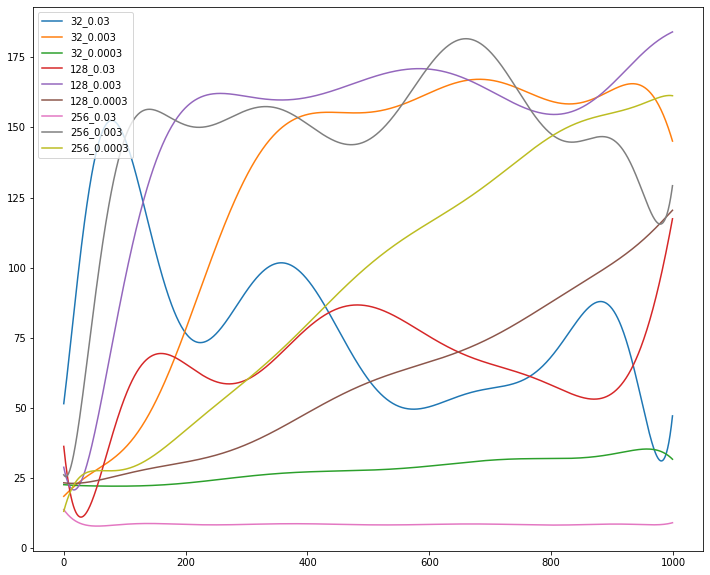

In [0]:
plt.figure(figsize=(12,10))
for i,lab in zip(episode_lens,labels):
  poly = np.polyfit(np.arange(1000),i,10)
  poly_y = np.poly1d(poly)(np.arange(1000))
  plt.plot(np.arange(1000), poly_y, label=lab)
plt.legend()
plt.show()

So, the best hyper parameters: 3e-3 for learning rate and 128 for hidden size.

#  Actor-Critic


In [0]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size):
        super(Actor, self).__init__()
        self.action_dim = action_dim
        self.l1 = nn.Linear(state_dim, hidden_size)
        self.l2 = nn.Linear(hidden_size, action_dim)

    def forward(self, state):
        x = F.relu(self.l1(state))
        x = F.softmax(self.l2(x), dim=-1)
        return x 
    

class Critic(nn.Module):
    def __init__(self, state_dim, hidden_size):
        super(Critic, self).__init__()
        self.l1 = nn.Linear(state_dim, hidden_size)
        self.l2 = nn.Linear(hidden_size, 1)
        

    def forward(self, state):
        x = F.relu(self.l1(state))
        x = self.l2(x)
        return x 
    

In [0]:
def actor_critic(seed=0, silent=True, hidden_size=128, max_episode_nums = 2000, lr=3e-3):
    env = gym.make('CartPole-v0')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    env.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    
    max_episode_num = max_episode_nums
    max_steps = 10000
    numsteps = []
    avg_numsteps = []
    all_rewards = []
    episode_count = []
    episode_len = []

    actor = Actor(state_dim, action_dim, hidden_size).to(device)
    critic = Critic(state_dim, hidden_size).to(device)
    actor_optimizer = optim.Adam(actor.parameters(), lr=lr)
    critic_optimizer = optim.Adam(critic.parameters(), lr=lr)

    for episode in range(max_episode_num):
      state = env.reset()
      rewards = []
      log_probs = []
      deltas = []
      values = []
      dones = []
      for steps in range(max_steps):
        state = torch.FloatTensor(state).to(device)
        dist, value = actor(state), critic(state)
        m = Categorical(dist)
        action = m.sample()
        new_state, reward, done, _ = env.step(action.item())
        new_state = torch.FloatTensor(new_state).to(device)
        new_value = critic(new_state)

        rewards.append(torch.tensor([reward]))
        log_probs.append(m.log_prob(action).unsqueeze(0))
        values.append(value)
        dones.append(torch.tensor([1-done], dtype=torch.float, device=device))
        
        state = new_state

        if done:
          next_state = torch.FloatTensor(new_state).to(device)
          next_value = critic(next_state)
          log_probs = torch.cat(log_probs)
          returns = []
          for t in reversed(range(len(rewards))):
            next_value = rewards[t] + gamma * next_value * dones[t]
            returns.insert(0, next_value)

          returns = torch.cat(returns).detach()
          values = torch.cat(values)
          delta = returns - values
          actor_loss = -(log_probs * delta.detach()).mean()
          critic_loss = -(delta.detach()*values).mean()

          actor_optimizer.zero_grad()
          actor_loss.backward()
          actor_optimizer.step()

          critic_optimizer.zero_grad()       
          critic_loss.backward()
          critic_optimizer.step()

          numsteps.append(steps)
          avg_numsteps.append(np.mean(numsteps[-10:]))
          all_rewards.append(np.sum(rewards))
          if not silent:
              print("episode: {}, total reward: {}, average_reward: {}\n".format(episode, np.round(np.sum(rewards), decimals = 3), steps))
          episode_count.append(episode)
          episode_len.append(steps)
          break

    return episode_count, episode_len
  
    

## Hyperparameters

In [0]:
labels, episode_lens = [], []
hidden_sizes = [32, 128, 256]
lrs = [3e-2, 3e-3, 3e-4]
for hs in hidden_sizes:
  for lr in lrs:
    el = []
    episode_count, episode_len_1 = actor_critic(seed=45, silent=True, hidden_size=hs, max_episode_nums = 1000, lr=lr)
    el.append(episode_len_1)
    episode_count, episode_len_2 = actor_critic(seed=74, silent=True, hidden_size=hs, max_episode_nums = 1000, lr=lr)
    el.append(episode_len_2)
    episode_lens.append(np.array(el).mean(axis=0))
    labels.append(str(hs)+'_'+str(lr))

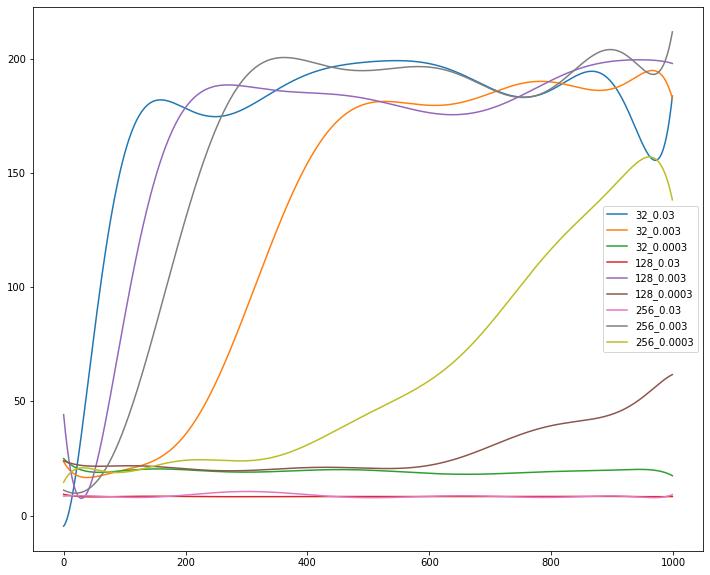

In [0]:
plt.figure(figsize=(12,10))
for i,lab in zip(episode_lens,labels):
  poly = np.polyfit(np.arange(1000),i,10)
  poly_y = np.poly1d(poly)(np.arange(1000))
  plt.plot(np.arange(1000), poly_y, label=lab)
plt.legend()
plt.show()

So, the best hyper parameters: 3e-3 for learning rate and 256 for hidden size.

# Runs

In [0]:
rein_episode_counts, rein_episode_lens = [], []
ac_episode_counts, ac_episode_lens = [], []
for seed in [0,1,2,3,4]:
  episode_count, episode_len = reinforce(seed = seed)
  # rein_episode_counts.append(episode_count)
  rein_episode_lens.append(episode_len)
  episode_count, episode_len = actor_critic(seed = seed)
  # ac_episode_counts.append(episode_count)
  ac_episode_lens.append(episode_len)

In [0]:
rein_episode_lens_ = np.array(rein_episode_lens)
ac_episode_lens_ = np.array(ac_episode_lens) 

In [0]:
rein_episode_lens_mean = rein_episode_lens_.mean(axis=0)
rein_episode_lens_sd = rein_episode_lens_.std(axis=0)
ac_episode_lens_mean = ac_episode_lens_.mean(axis=0)
ac_episode_lens_sd = ac_episode_lens_.std(axis=0)

In [0]:
x_axis = np.arange(2000)

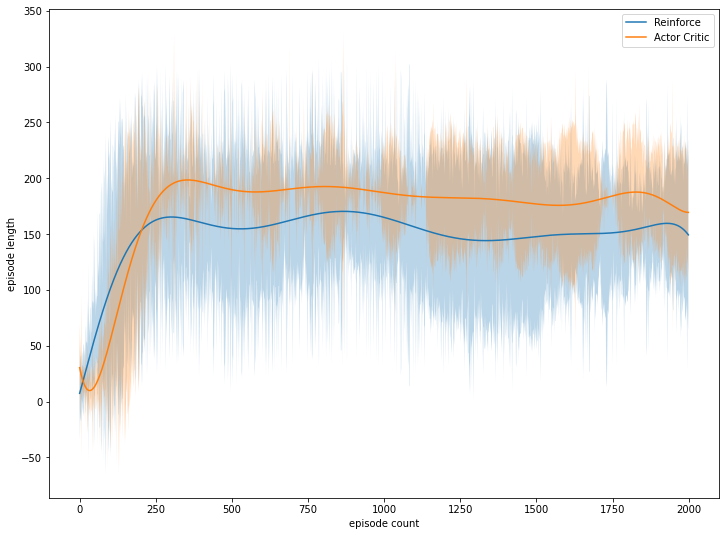

In [0]:
plt.figure(figsize=(12,9))
poly = np.polyfit(np.arange(2000),rein_episode_lens_mean,10)
poly_rein = np.poly1d(poly)(np.arange(2000))
plt.plot(x_axis,poly_rein, label='Reinforce')
plt.fill_between(x_axis, 
                 poly_rein-1.96*rein_episode_lens_sd,
                 poly_rein+1.96*rein_episode_lens_sd, alpha=0.3)
poly = np.polyfit(np.arange(2000),ac_episode_lens_mean,10)
poly_ac = np.poly1d(poly)(np.arange(2000))
plt.plot(x_axis, poly_ac, label='Actor Critic')
plt.fill_between(x_axis, 
                 poly_ac-1.96*ac_episode_lens_sd,
                 poly_ac+1.96*ac_episode_lens_sd, alpha=0.3)
plt.legend()
plt.xlabel('episode count')
plt.ylabel('episode length')
plt.show()

After training for 2k episodes, the plot shows that the two algorithms converged. My manual runs and the 95% confidence interval shows that the REINFORCE algorithm is capable to solve the task. However, actor-critic performed better as expected. 

Since fluctiations result an ugly graph, I fitted a polinomial function to see clearly the results. I also normalized the rewards in REINFORCE to have better results. I coded both algorithms extravagantly in terms of memory, they might be faster after rearranging.

While playing with the hyperparameters and some specific details in implementation, I observed that Actor-Critic is more vulnarable to these changes. So, hyperparameter tuning is really important.

All in all, actor-critic method actually adds baseline to REINFORCE using critic. In our implementation, REINFORCE is an unbiased method, on the other hand, actor-critic is a biased method. I observed that actor-critic converged faster than REINFORCE, it reaches 200 corridor very quicly compared to REINFORCE. However, in the last plot REINFORCE seems to have higher values earlier than actor-critic. 

